In [1]:
import psycopg2
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import collections
import pandas as pd
import matplotlib

In [2]:
# Function to connect to the PostgreSQL database
def connect_to_db():
    connection = psycopg2.connect(    
        dbname= 'socialmedia',
        user= 'postgres',
        password= 'password',
        host= 'localhost',  
        port= '5432'
    )
    return connection


In [3]:
def run_query(query, values=[]):
    connection = connect_to_db()
    cursor = connection.cursor()
    cursor.execute(query,values)
    data = cursor.fetchall()
    # Close the database connection
    cursor.close()
    connection.close()
    return data


In [4]:
subreddit2cat = {
    "typescript":"Typescript",
    "NixOS":"Nix",
    "rust":"Rust",
    "FlutterDev":"Flutter",
    "golang":"Go",
    "kubernetes":"Kubernetes",
    "swift":"Swift"
}

repo2cat = {
    "NixOS_nixpkgs":"Nix",
    "flutter_flutter":"Flutter",
    "golang_go":"Go",
    "kubernetes_kubernetes":"Kubernetes",
    "rust-lang_rust":"Rust",
    "apple_swift":"Swift",
    "microsoft_TypeScript":"Typescript"
}

subreddit_names = ["typescript",
        "NixOS",
        "rust",
        "FlutterDev",
        "golang",
        "kubernetes",
        "swift"]
repo_names = repo2cat.keys()

## Reddit Response Time on a post

In [40]:
# Function to perform the analysis and write results to a file
def first_comment_reddit(subreddits, output_file):
    connection = connect_to_db()
    cursor = connection.cursor()
    

    query = """
        select 
        a.subreddit,
        a.post_name,
        a.created_utc,
        b.created_utc 
    from reddit_posts a 
    inner join 
    (
        select 
            c.post_name,
            c.subreddit,
            c.created_utc from 
            (
                select 
                    post_name, 
                    subreddit,
                    comment_id, 
                    created_utc, 
                    rank() over (partition by post_name order by created_utc asc) rank_number 
                from reddit_comments where subreddit!='politics'
            )c 
        where c.rank_number=1
    )b
    on a.post_name=b.post_name
    and a.subreddit = b.subreddit
    and a.subreddit!='politics';
    """
    cursor.execute(query, (tuple(subreddits),))
    data = cursor.fetchall()
    
    subreddits = set(row[0] for row in data)
    subreddit_data = {subreddit: [] for subreddit in subreddits}

    for row in data:
        if row[0] is not None and row[0] != 'politics' and row[1] is not None and row[2] is not None:
            subreddit_data[row[0]].append(((row[3] - row[2]).total_seconds() / 60)/60)

    # Make sure the colors list matches the number of subreddits
    colors = ['skyblue', 'lightgreen', 'coral', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']

    values = []
    for k, v in subreddit_data.items():
        values.append([k, sum(v)/len(v)])
    
    values.sort(key=lambda x:x[1], reverse=False)
    for i, (subreddit, avg_time) in enumerate(values):
        plt.bar(subreddit, avg_time, label=subreddit)
    plt.xlabel('Subreddit')
    plt.ylabel('Average Response Time (Hrs)')
    #rotate xticks
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    # Save the plot to a file
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

    # Close the database connection
    cursor.close()
    connection.close()


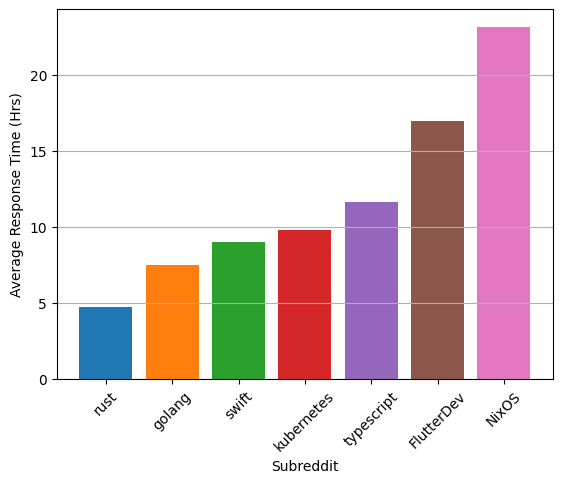

In [41]:

output_file_name = "response_time_analysis.pdf"
first_comment_reddit(subreddit_names, output_file_name)


In [42]:
def active_reddit_post_time(filename):
    query = """
    select
        first.subreddit,
        first.post_name,
        last.created_utc-first.created_utc as active_time
    from
    (
        select 
        a.subreddit,
        a.post_name,
        b.created_utc 
    from reddit_posts a 
    inner join 
    (
        select 
            c.post_name,
            c.subreddit,
            c.created_utc from 
            (
                select 
                    post_name, 
                    subreddit,
                    comment_id, 
                    created_utc, 
                    rank() over (partition by post_name order by created_utc desc) rank_number 
                from reddit_comments where subreddit!='politics'
            )c 
        where c.rank_number=1
    )b
    on a.post_name=b.post_name
    and a.subreddit = b.subreddit
    and a.subreddit!='politics'
    ) last
    inner join
    (
        select 
        a.subreddit,
        a.post_name,
        b.created_utc 
    from reddit_posts a 
    inner join 
    (
        select 
            c.post_name,
            c.subreddit,
            c.created_utc from 
            (
                select 
                    post_name, 
                    subreddit,
                    comment_id, 
                    created_utc, 
                    rank() over (partition by post_name order by created_utc asc) rank_number 
                from reddit_comments where subreddit!='politics'
            )c 
        where c.rank_number=1
    )b
    on a.post_name=b.post_name
    and a.subreddit = b.subreddit
    and a.subreddit!='politics'
    )first
    on first.post_name=last.post_name
    and first.subreddit=last.subreddit
    ;
    """
    data = run_query(query)
    subreddits = set(row[0] for row in data)
    subreddit_data = {subreddit: [] for subreddit in subreddits}

    for row in data:
        if row[0] is not None and row[0] != 'politics' and row[1] is not None and row[2] is not None:
            subreddit_data[row[0]].append(((row[2]).total_seconds() / 60)/60)
    
    
    # Make sure the colors list matches the number of subreddits
    colors = ['skyblue', 'lightgreen', 'coral', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']

    values = []
    for k, v in subreddit_data.items():
        values.append([k, sum(v)/len(v)])

    values.sort(key=lambda x:x[1], reverse=False)
    for i, (subreddit, avg_time) in enumerate(values):
        plt.bar(subreddit, avg_time, label=subreddit)
    plt.xlabel('Subreddit')
    plt.ylabel('Average Active Time (Hrs)')
    plt.grid(axis='y')
    # Save the plot to a file
    plt.xticks(rotation=45)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

            

    

        

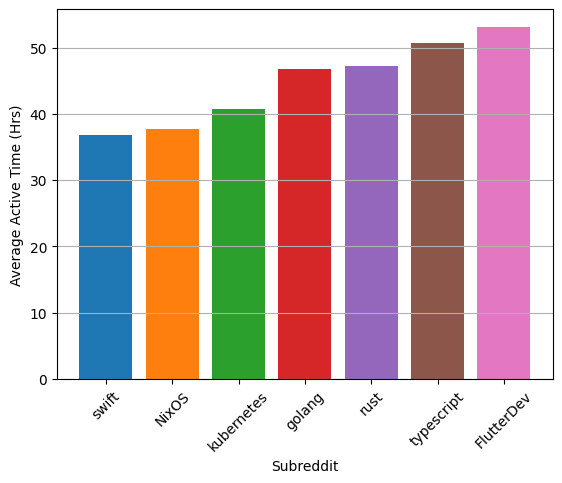

In [43]:
active_reddit_post_time("active_time_analysis.pdf")

## Github Response time on an Issue

In [94]:
def first_comment_git(output_file):
    connection = connect_to_db()
    cursor = connection.cursor()
        
    query = """
        select 
        a.repo_name,
        a.issue_number,
        a.created_dt,
        b.created_at 
    from github_issues a 
    inner join 
    (
        select 
            c.issue_number,
            c.repo_name,
            c.comment_id,
            c.created_at from 
            (
                select 
                    issue_number, 
                    repo_name,
                    comment_id, 
                    created_at, 
                    rank() over (partition by repo_name, issue_number order by created_at asc) rank_number 
                from github_comments
            )c 
        where c.rank_number=1
    )b
    on a.issue_number=b.issue_number
    and a.repo_name = b.repo_name;
    """
    cursor.execute(query)
    data = cursor.fetchall()
    
    # Close the database connection
    cursor.close()
    connection.close()
    
    repos_data = collections.defaultdict(list)

    for row in data:
        if row[0] and row[1] and row[2] and row[3] :
            repos_data[row[0].split('_')[1]].append(((row[3] - row[2]).total_seconds() / 60)/60)


    # Make sure the colors list matches the number of subreddits
    colors = ['skyblue', 'lightgreen', 'coral', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']
    values = []
    for k, v in repos_data.items():
        values.append([k, sum(v)/len(v)])
    
    values.sort(key=lambda x:x[1], reverse=False)
    for i, (repo, avg_time) in enumerate(values):
        plt.bar(repo, avg_time, label=repo)
    plt.xlabel('Repository')
    plt.ylabel('Average First Response Time (Hrs)')
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()




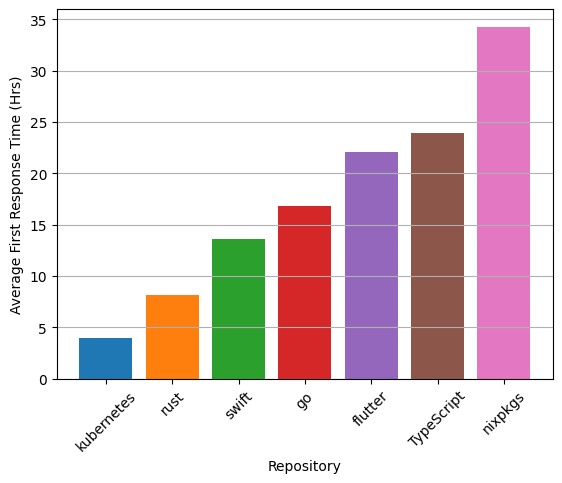

In [95]:
output_file_name = "average_response_time_github_repos.pdf"
first_comment_git(output_file_name)


## Compare First Interaction on Reddit and Github

In [92]:
def compare_first_time(filename):
    # Get git data
    colors = ['skyblue', 'lightgreen', 'coral', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']

        
    query = """
        select 
        a.repo_name,
        a.issue_number,
        a.created_dt,
        b.created_at 
    from github_issues a 
    inner join 
    (
        select 
            c.issue_number,
            c.repo_name,
            c.comment_id,
            c.created_at from 
            (
                select 
                    issue_number, 
                    repo_name,
                    comment_id, 
                    created_at, 
                    rank() over (partition by repo_name, issue_number order by created_at asc) rank_number 
                from github_comments
            )c 
        where c.rank_number=1
    )b
    on a.issue_number=b.issue_number
    and a.repo_name = b.repo_name;
    """
    data = run_query(query)

    repos_data = collections.defaultdict(list)

    for row in data:
        if row[0] and row[1] and row[2] and row[3] :
            repos_data[repo2cat[row[0]]].append(((row[3] - row[2]).total_seconds() / 60)/60)

    query = """
        select 
        a.subreddit,
        a.post_name,
        a.created_utc,
        b.created_utc 
    from reddit_posts a 
    inner join 
    (
        select 
            c.post_name,
            c.subreddit,
            c.created_utc from 
            (
                select 
                    post_name, 
                    subreddit,
                    comment_id, 
                    created_utc, 
                    rank() over (partition by post_name order by created_utc asc) rank_number 
                from reddit_comments where subreddit!='politics'
            )c 
        where c.rank_number=1
    )b
    on a.post_name=b.post_name
    and a.subreddit = b.subreddit
    and a.subreddit!='politics';
    """
    data = run_query(query)

    subreddit_data = collections.defaultdict(list)
    for row in data:
        if row[0] is not None and row[0] != 'politics' and row[1] is not None and row[2] is not None:
            subreddit_data[subreddit2cat[row[0]]].append(((row[3] - row[2]).total_seconds() / 60)/60)
    
    X = subreddit2cat.values()
    labels = ['Github', "Reddit"]
    Y = []
    Z = []
    for x in X:
        Y.append(sum(repos_data[x])/len(repos_data[x]))
        Z.append(sum(subreddit_data[x])/len(subreddit_data[x]))

    def subcategorybar(X, vals, labels,width=0.6):
        n = len(vals)
        _X = np.arange(len(X))
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge",label=labels[i])   
        plt.xticks(_X, X)
    
    subcategorybar(X,[Y,Z],labels)
    plt.ylabel('Average first Response Time (Hrs)')
    plt.xlabel('Technology Stack')
    plt.grid(axis='y')
    plt.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

    

    


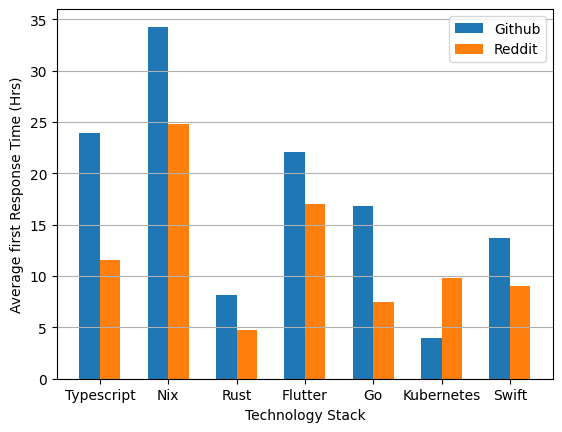

In [93]:
compare_first_time("compare_first_comment_time.pdf")

## Github Issue Close Time

In [48]:
def get_avg_close_time(filename):
    query = """
        select repo_name, issue_number, created_dt, closed_at from github_issues where state = 'closed' and closed_at is not null;
    """
    data = run_query(query)

    repos_data = collections.defaultdict(list)
    for row in data:
        if row[0] and row[1] and row[2] and row[3]:
            repos_data[repo2cat[row[0]]].append(((row[3] - row[2]).total_seconds() / 60)/60)
    
    # Make sure the colors list matches the number of subreddits
    colors = ['skyblue', 'lightgreen', 'coral', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']
    values = []
    for k, v in repos_data.items():
        values.append([k, sum(v)/len(v)])
    
    values.sort(key=lambda x:x[1], reverse=False)
    for i, (repo, avg_time) in enumerate(values):
        plt.bar(repo, avg_time, label=repo)
    
    plt.xlabel('Repository')
    plt.ylabel('Average Issue Resolution Time (Hrs)')
    # rotate axis labels and increase size

    plt.xticks(fontsize=10, rotation=45)
    plt.grid(axis='y')
    # Save the plot to a file
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


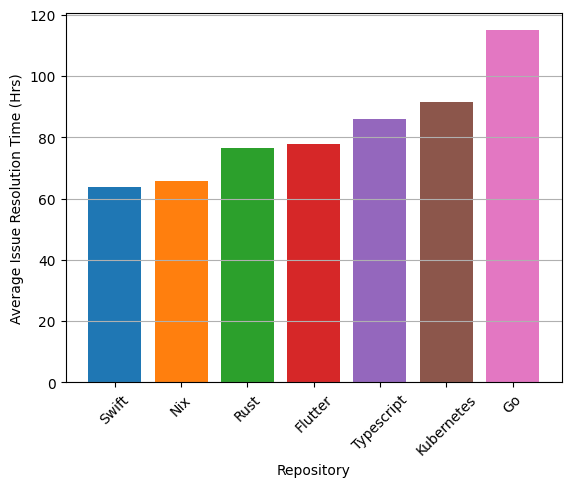

In [49]:
get_avg_close_time("average_issue_close_time_github_repos.pdf")

## Reddit Comments Toxicity

In [50]:
def compare_toxicity_among_subreddits(filename):

    query = """
        select 
            count(*) as comment_count, 
            subreddit 
            from reddit_comments 
        where comment_id in 
        (
            select 
                comment_id 
            from 
                reddit_comments_sentiment 
            where 
            class != 'normal'
        ) 
        group by subreddit
        order by count(*);
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['comment_count', 'subreddit'])
    # Plot the bar graph
    plt.bar(df['subreddit'], df['comment_count'])
    plt.xlabel('Subreddit')
    plt.ylabel('# of comments')
    plt.grid(axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.savefig(filename, bbox_inches='tight')

    plt.show()

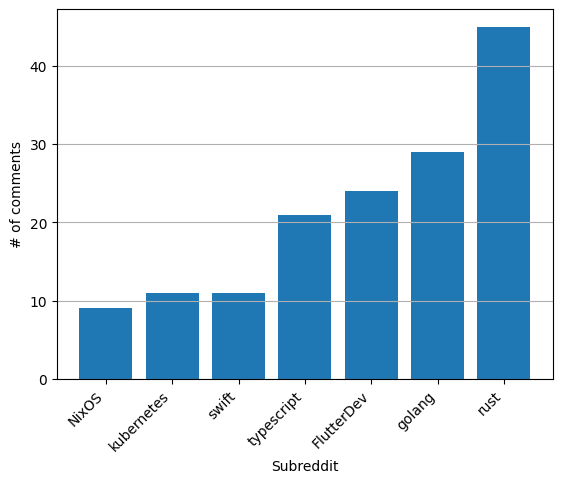

In [51]:
compare_toxicity_among_subreddits("toxicity_on_reddit.pdf")

## Reddit Toxic Comments Word Map

In [33]:
# Importing the Libraries
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

In [52]:
## Create word map for the comments that are toxic
def create_word_map(filename):
    query = """
        select
            body
        from
            reddit_comments
        where
            comment_id in 
            (
                select 
                    comment_id 
                from 
                    reddit_comments_sentiment 
                where 
                    class != 'normal'
            );
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    text = "".join([row[0] for row in data])
    text = text.lower()
    stop_words = set(STOPWORDS) 
    final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 4).generate(text) 
    # Plotting the WordCloud                    
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(final_wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    # save the image
    plt.savefig(filename, bbox_inches='tight')

    plt.show() 

     

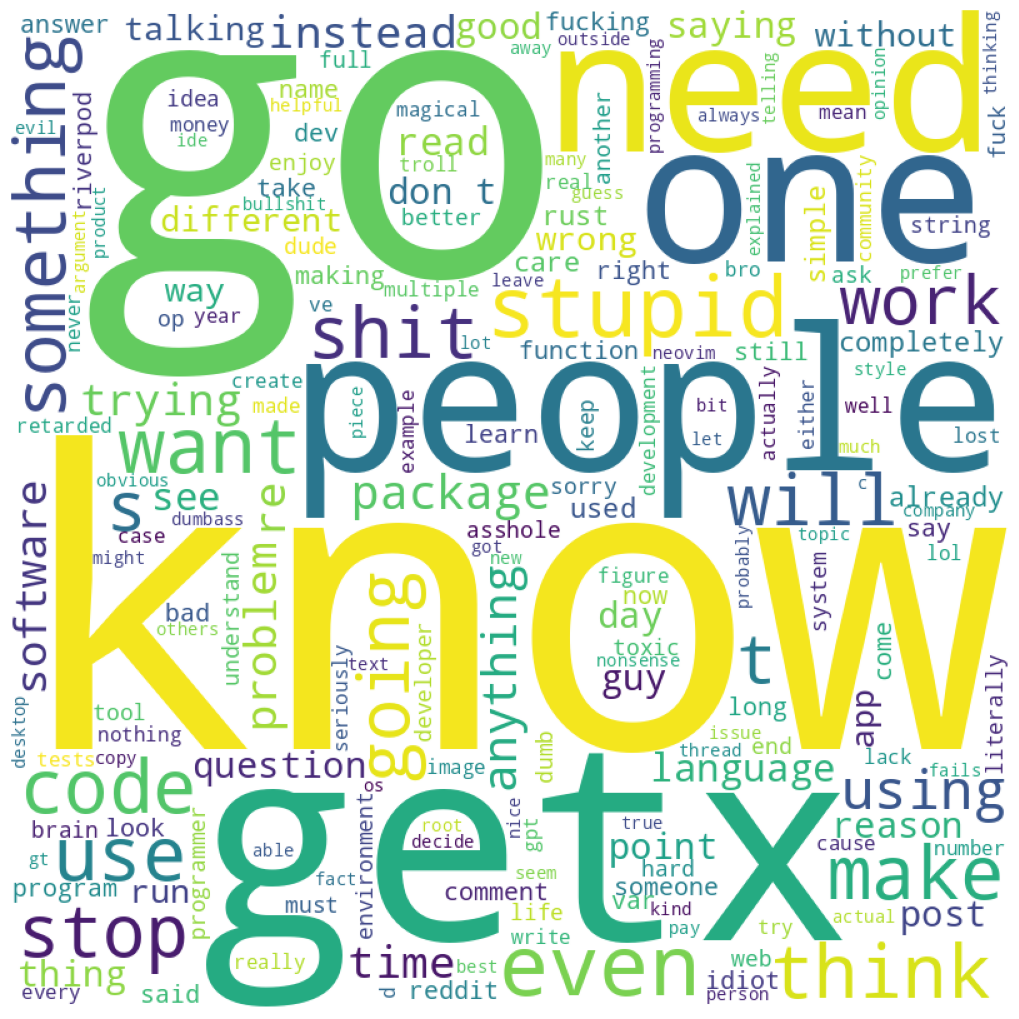

In [53]:
create_word_map("word_map_toxic_comments.pdf")

## Reddit Toxic Comments Comman Words

In [12]:
from nltk.util import ngrams

In [54]:
## create bigrams for the comments that are toxic
def get_ngrams_from_toxic_comments(n, filename,xlabel,ylabel):
    query = """
        select
            body
        from
            reddit_comments
        where
            comment_id in 
            (
                select 
                    comment_id 
                from 
                    reddit_comments_sentiment 
                where 
                    class != 'normal'
            );
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    stop_words = set(STOPWORDS) 
    bigram_dict = collections.defaultdict(int)
    for row in data:
        line = row[0].lower()
        tokens = line.split()
        tokens = [word for word in tokens if word not in stop_words]
        bigrams = ngrams(tokens, n)
        for bigram in bigrams:
            bigram_dict[" ".join((bigram))] += 1
    # Create a DataFrame from the dictionary
    sorted_bigrams = sorted(bigram_dict.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(list(bigram_dict.items()), columns=['data', 'count'])
    # Sort the DataFrame by the bigram count
    df = df.sort_values(by='count', ascending=False)
    # Plot the bar graph
    fig, ax = plt.subplots()
    ax.bar(df['data'].head(10), df['count'].head(10))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(df['data'].head(10), rotation=45, ha='right')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.grid(axis='y')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_896284/3219635274.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['data'].head(10), rotation=45, ha='right')


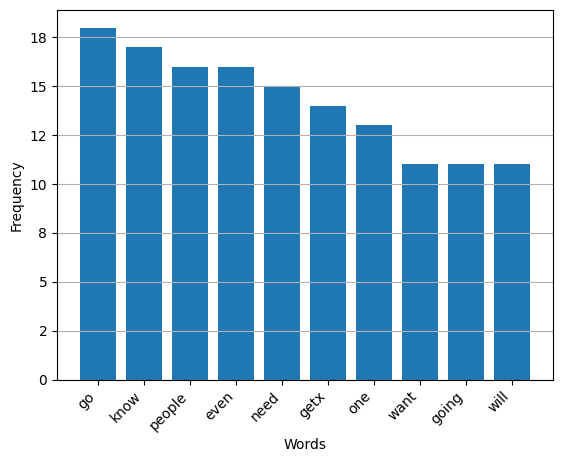

In [55]:
get_ngrams_from_toxic_comments(1, "most_comman_words_toxic_comments.pdf","Words", "Frequency")

/tmp/ipykernel_896284/3219635274.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['data'].head(10), rotation=45, ha='right')


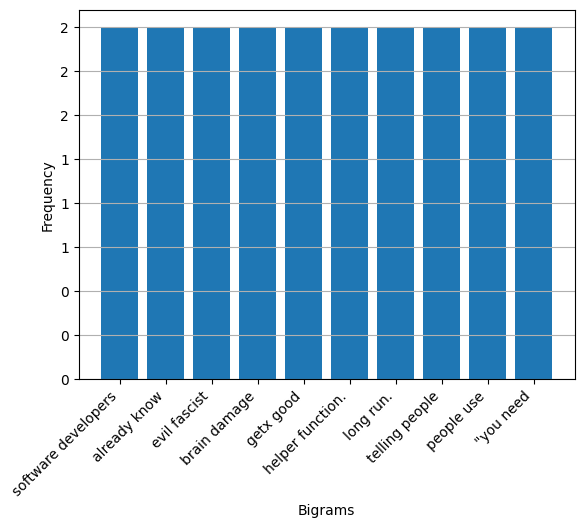

In [56]:
get_ngrams_from_toxic_comments(2, "bigrams_toxic_comments.pdf","Bigrams", "Frequency")

/tmp/ipykernel_896284/3219635274.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['data'].head(10), rotation=45, ha='right')


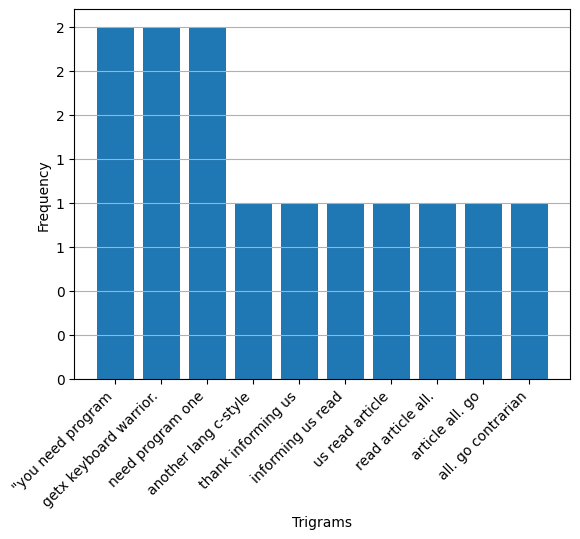

In [57]:
get_ngrams_from_toxic_comments(3,"trigrams_toxic_comments.pdf", "Trigrams", "Frequency")

## Using Vader Sentiment Analysis

In [58]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

def run_vader_and_create_graph(data, columns, filename):
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=columns)
    # Instantiate the SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    # Create a new column to store the sentiment scores
    df['scores'] = df['body'].apply(lambda body: sid.polarity_scores(body))
    # Create a new column to store the compound scores
    df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
    # Create a new column to store the sentiment
    df['sentiment'] = df['compound'].apply(lambda c: 'positive' if c > 0 else ( 'neutral' if c==0 else 'negative'))
    # Plot the bar graph
    plt.figure()
    plt.bar(df['sentiment'].value_counts().index, df['sentiment'].value_counts(), width=0.5)
    plt.xlabel('Sentiment')
    plt.ylabel('# of Comments')
    plt.grid(axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    return df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/arasal2/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [59]:

def run_vader_on_non_toxic_reddit_comments(filename):
    query = """
        select
            body
        from
            reddit_comments
        where
            comment_id in 
            (
                select 
                    comment_id 
                from 
                    reddit_comments_sentiment 
                where 
                    class = 'normal'
            );
        """

    data = run_query(query)
    df = run_vader_and_create_graph(data, ['body'], filename)
    return df





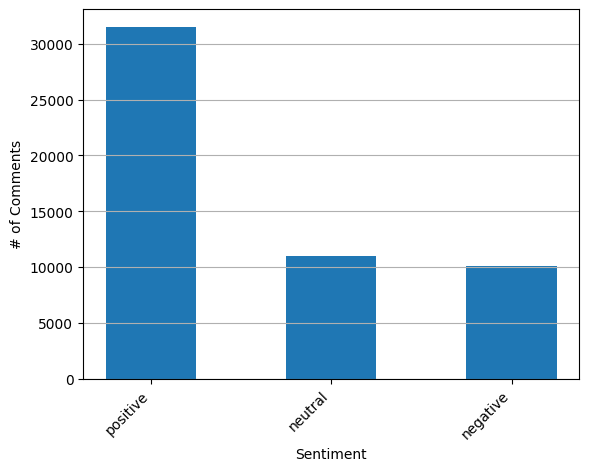

In [60]:
df = run_vader_on_non_toxic_reddit_comments("vader_on_non_toxic_comments.pdf")

In [61]:
def run_vader_on_non_toxic_github_comments(filename):
    query = """
        select
            body
        from
            github_comments
        where
            comment_id in
            (
                select 
                    cast(comment_id as integer)
                from 
                    github_comments_sentiment 
                where 
                    class = 'normal'
            );
        """

    data = run_query(query)
    df = run_vader_and_create_graph(data, ['body'], filename)
    return df

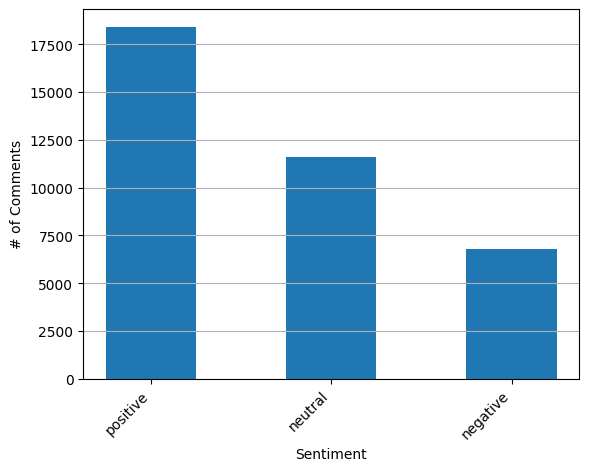

In [62]:
df = run_vader_on_non_toxic_github_comments("vader_on_non_toxic_github_comments.pdf")

## Activity per day on Reddit and Github

In [63]:
def posts_and_comments_per_date_reddit(filename):
    query1 = """
        select 
            count(*) as comment_count, 
            date_trunc('day', created_utc) as day
            from reddit_comments 
        where subreddit!='politics'
        and created_utc > '2023-10-20'
        group by day
        order by day;
        """
    
    data1= run_query(query1)

    query2 = """
        select 
            count(*) as post_count, 
            date_trunc('day', created_utc) as day
            from reddit_posts 
        where subreddit!='politics'
        and created_utc > '2023-10-20'
        group by day
        order by day;
        """
    data2 = run_query(query2)


    # Create a DataFrame from the query result
    df1 = pd.DataFrame(data1, columns=['comment_count', 'day'])
    df2 = pd.DataFrame(data2, columns=['post_count', 'day'])

    # plot the line graph using log scale
    fig, ax = plt.subplots( figsize=(15, 8))
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d-%Y'))
    ax.plot(df1['day'], df1['comment_count'], label='Comments')
    ax.plot(df2['day'], df2['post_count'], label='Posts')
    fig.autofmt_xdate()
    ax.set_xlabel('Date')
    ax.set_ylabel('Record Count')
    ax.grid()

    ax.set_yscale('log')
    fig.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

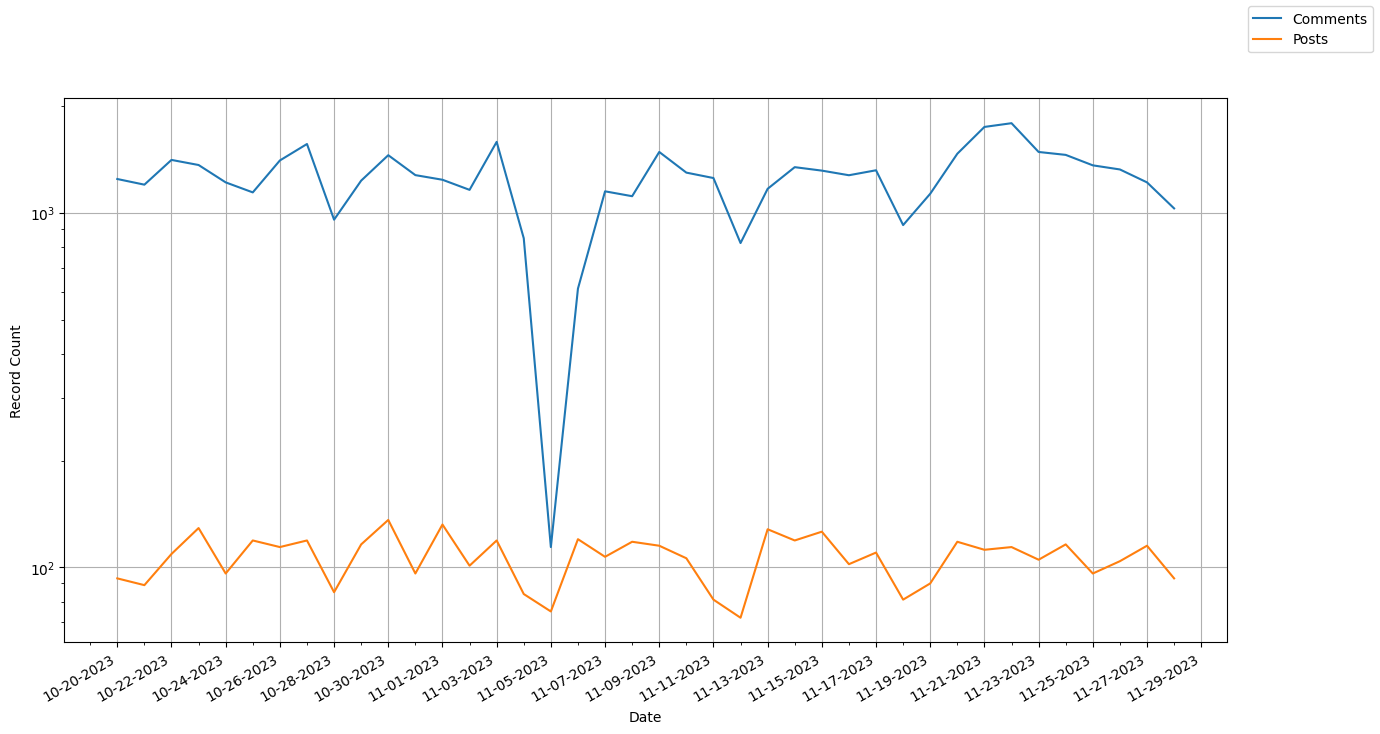

In [42]:
posts_and_comments_per_date_reddit("posts_comments_per_date_reddit.pdf")

In [64]:
def posts_and_comments_per_date_git(filename):
    query1 = """
        select 
            count(*) as comment_count, 
            date_trunc('day', created_at) as day
            from github_comments 
        where created_at > '2023-10-20'
        group by day
        order by day;
        """
    
    data1= run_query(query1)

    query2 = """
        select 
            count(*) as post_count, 
            date_trunc('day', created_dt) as day
            from github_issues 
        where created_dt > '2023-10-20'
        group by day
        order by day;
        """
    data2 = run_query(query2)


    # Create a DataFrame from the query result
    df1 = pd.DataFrame(data1, columns=['comment_count', 'day'])
    df2 = pd.DataFrame(data2, columns=['post_count', 'day'])

    # plot the line graph using log scale
    fig, ax = plt.subplots( figsize=(15, 8))
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d-%Y'))
    ax.plot(df1['day'], df1['comment_count'], label='Comments')
    ax.plot(df2['day'], df2['post_count'], label='Posts')
    fig.autofmt_xdate()
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.grid()

    ax.set_yscale('log')
    fig.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

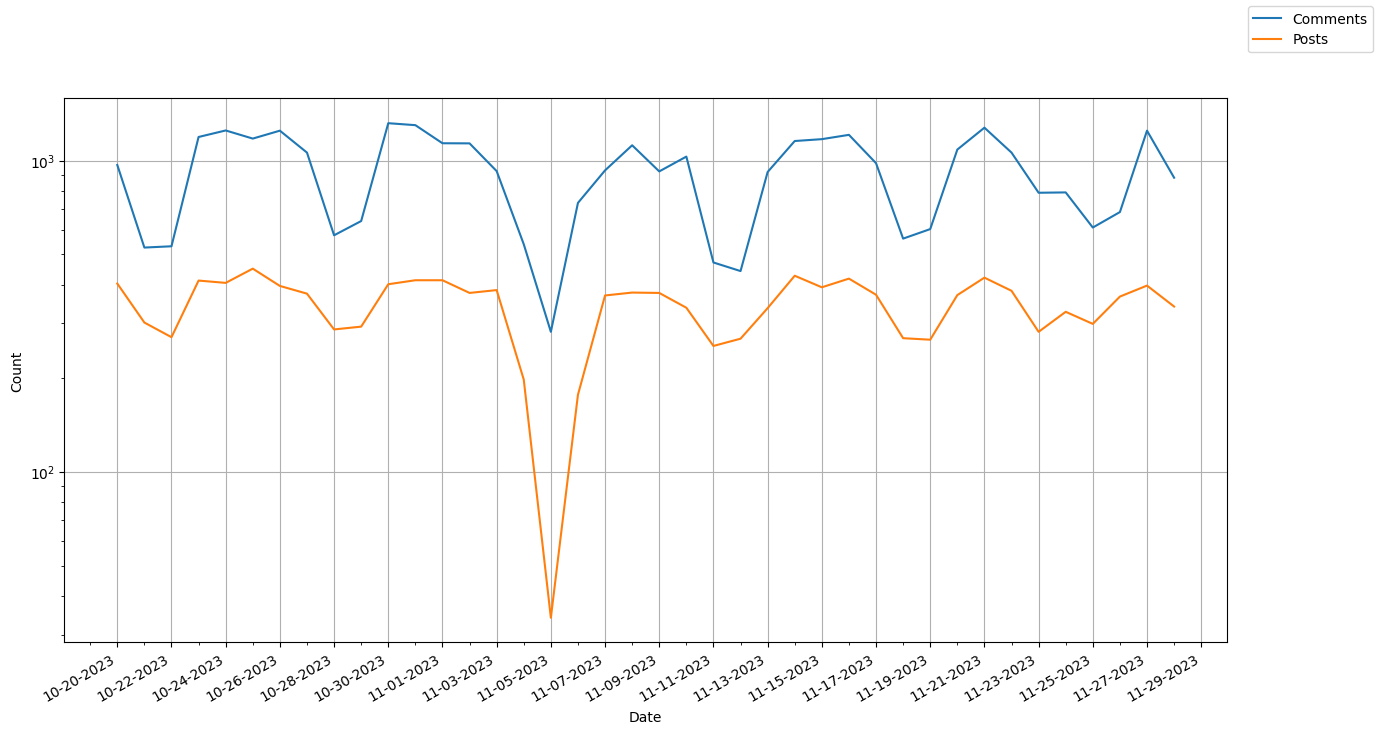

In [65]:
posts_and_comments_per_date_git("posts_comments_per_date_git.pdf")

In [7]:
def unique_users_per_day(filename):

    query = """
    select
        count(distinct a.author_fullname) as unique_users,
        a.date,
        a.subreddit
    from
    (
    
        Select 
        author_fullname,
        created_utc::timestamp::date as date,
        subreddit
        from
        reddit_comments
        where subreddit!='politics'
            and inserted_at > now() - interval '7 day'
        union
        select
        author_fullname,
        created_utc::timestamp::date as date,
        subreddit
        from
        reddit_posts
        where subreddit!='politics'
            and  inserted_at > now() - interval '7 day'
    )a
    group by a.date,a.subreddit
    order by a.date;
    """

    data = run_query(query)
    subreddit_names = ["typescript",
            "NixOS",
            "rust",
            "FlutterDev",
            "golang",
            "kubernetes",
            "swift"]
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['unique_users', 'date', 'subreddit'])
    # Plot the line graph comparing the number of unique users per day among subreddits
    fig, ax = plt.subplots( figsize=(15, 8))
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m.%d.%Y'))
    for subreddit in subreddit_names:
        ax.plot(df[df['subreddit'] == subreddit]['date'], df[df['subreddit'] == subreddit]['unique_users'], label=subreddit)
    ax.set_xlabel('Date')
    ax.set_ylabel('Unique Users/day')
    ax.grid()
    fig.autofmt_xdate()
    ax.legend(loc='upper left')
    plt.savefig(filename, bbox_inches='tight')
    

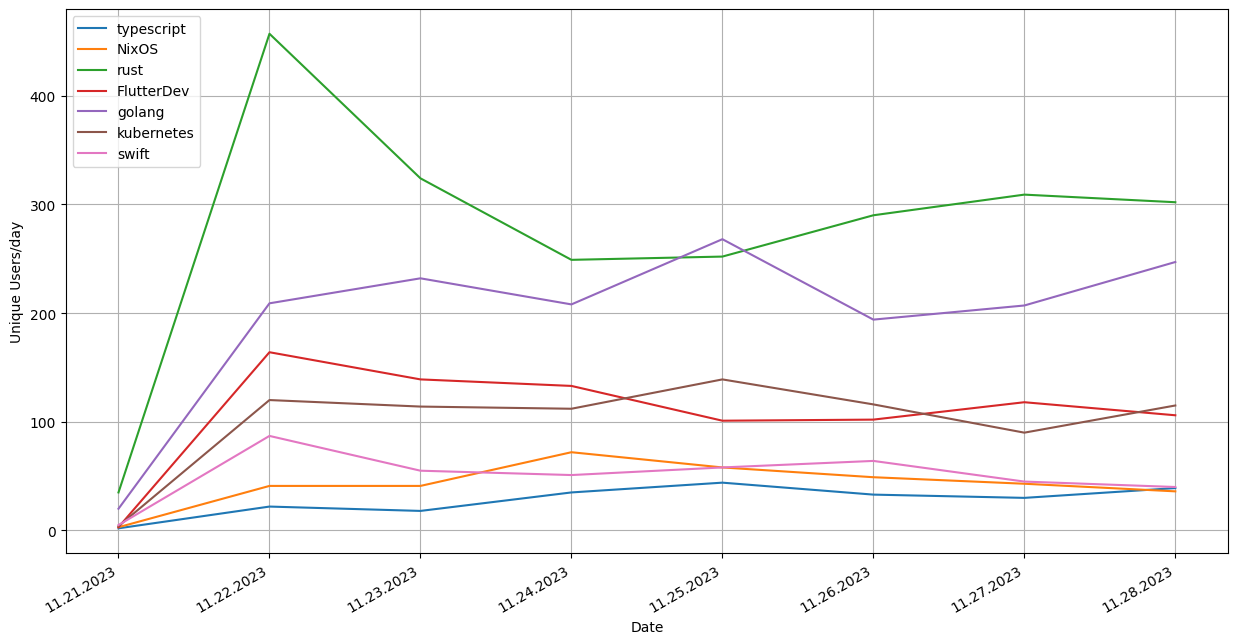

In [8]:
unique_users_per_day("unique_users_per_day.pdf")

## Get the details about the content of the post


In [68]:
def create_cdf_of_reddit(filename):
    query = """
        select 
            length(title) as length
        from 
            reddit_posts 
        where subreddit!='politics';
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['length'])
    # Plot the CDF
    plt.hist(df['length'], cumulative=True, density=True, bins=100, histtype='step', label='Reddit Posts Title')

    query = """
        select 
            length(selftext) as length
        from
            reddit_posts
        where subreddit!='politics';
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['length'])
    # Plot the histogram
    plt.hist(df['length'], cumulative=True,density=True, bins=1000, histtype='step', label='Reddit Posts Body')
    plt.xlabel('Text Length')

    # reddit comments
    query = """
        select 
            length(body) as length
        from
            reddit_comments
        where subreddit!='politics';
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['length'])
    # Plot the histogram
    plt.hist(df['length'], cumulative=True, density=True, bins=100, histtype='step', label='Reddit Comments')
    
    plt.xscale('log')
    plt.ylabel('Probability')
    plt.grid()
    plt.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

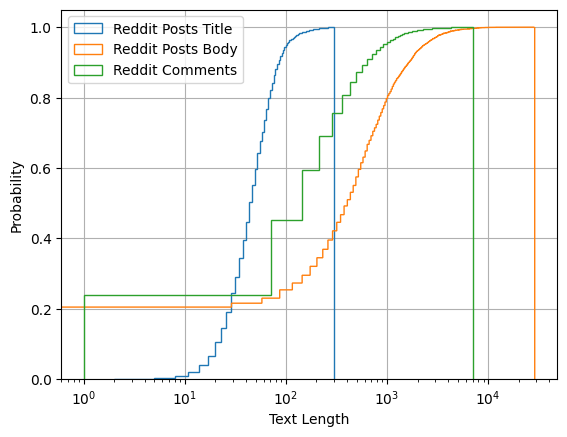

In [69]:
create_cdf_of_reddit("cdf_of_reddit_post_length.pdf")

In [70]:
def create_cdf_of_git(filename):
    query = """
        select 
            length(title) as length
        from 
            github_issues;
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['length'])
    # Plot the CDF
    plt.hist(df['length'], cumulative=True, density=True, bins=100, histtype='step', label='Github Issue Title')

    query = """
        select 
            length(body) as length
        from
            github_issues;
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['length'])
    # Plot the histogram
    plt.hist(df['length'], cumulative=True,density=True, bins=1000, histtype='step', label='Github Issue Body')
    plt.xlabel('Text Length')

    # github comments
    query = """
        select 
            length(body) as length
        from
            github_comments;
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['length'])
    # Plot the histogram
    plt.hist(df['length'], cumulative=True, density=True, bins=1000, histtype='step', label='Github Comments')
    
    plt.xscale('log')
    plt.ylabel('Probability')
    plt.grid()
    plt.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

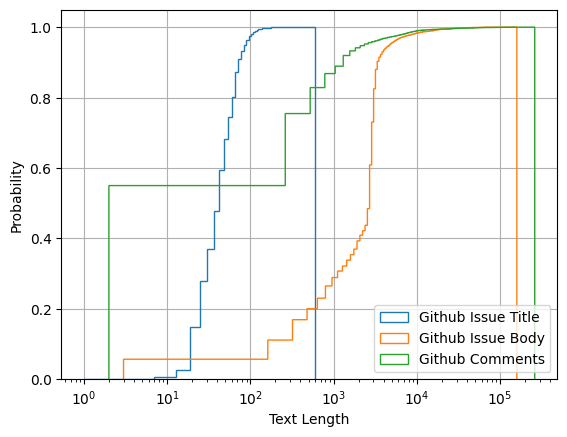

In [71]:
create_cdf_of_git("cdf_of_git_post_length.pdf")

In [72]:
def plot_upvotes_for_reddit(filename):
    query = """
        select 
            ups
        from 
            reddit_posts 
        where subreddit!='politics'
        group by ups
        order by ups;
        """
    
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['score'])

    # plot the cdf 
    plt.hist(df['score'], cumulative=True, density=True, bins=100, histtype='step', label='Reddit Posts Upvotes')

    query = """
        select 
            ups
        from
            reddit_comments
        where subreddit!='politics'
    """
    data = run_query(query)
    # Create a DataFrame from the query result  
    df = pd.DataFrame(data, columns=['score'])
    # Plot the cdf
    plt.hist(df['score'], cumulative=True, density=True, bins=100, histtype='step', label='Reddit Comments Upvotes')
    
    plt.xlabel('Upvotes')
    plt.ylabel('Probability')
    plt.xscale('log')
    plt.grid()
    plt.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    


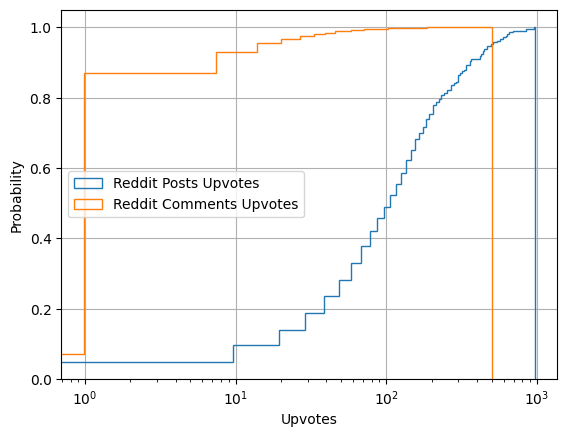

In [73]:
plot_upvotes_for_reddit("upvotes_vs_comments.pdf")

In [74]:
def total_data_over_time(filename):
    query1 = """
        select 
            count(*) as record_count,
            date_trunc('day', a.day) as day
        from 
        (
        select 
            date_trunc('day', inserted_at) as day
            from reddit_comments 
        where subreddit!='politics'
        and inserted_at > '2023-10-20'
        union all
        select 
            date_trunc('day', inserted_at) as day
            from reddit_posts 
        where subreddit!='politics'
        and inserted_at > '2023-10-20'
        union all
        select 
            date_trunc('day', inserted_at) as day
            from github_comments
            where inserted_at > '2023-10-20'

        union all
        select 
            date_trunc('day', inserted_at) as day
            from github_issues
            where inserted_at > '2023-10-20'
        )a
        group by day
        order by day;
        """
    
    data1= run_query(query1)

    # Create a DataFrame from the query result
    df1 = pd.DataFrame(data1, columns=['record_count', 'day'])
    
    # plot the line graph using log scale
    fig, ax = plt.subplots( figsize=(15, 8))
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d-%Y'))
    ax.plot(df1['day'], df1['record_count'], label='Total Records')
    fig.autofmt_xdate()
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.grid()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    

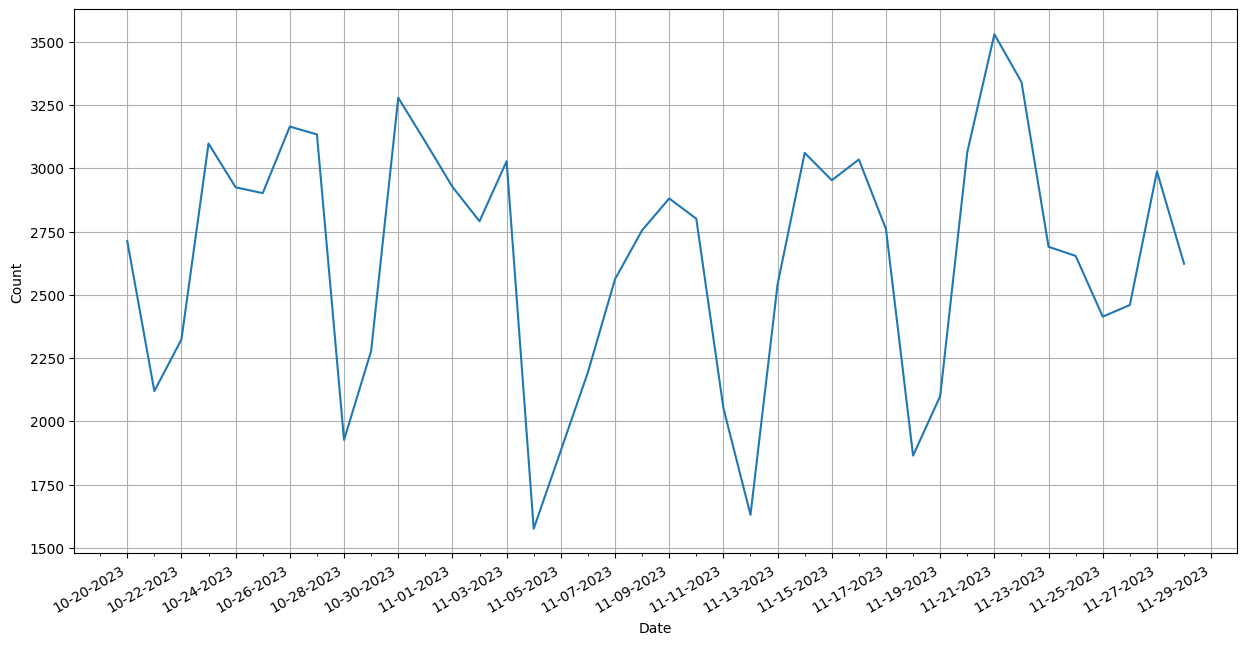

In [75]:
total_data_over_time("total_data_over_time.pdf")

In [76]:
def all_data_over_time(filename):
    query1 = """
        select
            source,
            record_count,
            day
        from
        (
        select 
            'Reddit Post' as source,
            count(*) as record_count,
            date_trunc('day',inserted_at) as day
        from
            reddit_posts
        where subreddit!='politics'
        and inserted_at > '2023-10-20'
        group by day
        union all
        select 
            'Reddit Comment' as source,
            count(*) as record_count,
            date_trunc('day',inserted_at) as day
        from
            reddit_comments
        where subreddit!='politics'
        and inserted_at > '2023-10-20'
        group by day
        union all
        select 
            'Github Issue' as source,
            count(*) as record_count,
            date_trunc('day',inserted_at) as day
        from
            github_issues
        where inserted_at > '2023-10-20'
        group by day
        union all
        select 
            'Github Comment' as source,
            count(*) as record_count,
            date_trunc('day',inserted_at) as day
        from
            github_comments
        where inserted_at > '2023-10-20'
        group by day
        )a
        order by a.day;
        """

    data1= run_query(query1)

    # Create a DataFrame from the query result
    df1 = pd.DataFrame(data1, columns=['source', 'record_count', 'day'])

    # plot the line graph using log scale
    fig, ax = plt.subplots( figsize=(15, 8))
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d-%Y'))
    for source in ['Reddit Post', 'Reddit Comment', 'Github Issue', 'Github Comment']:
        ax.plot(df1[df1['source'] == source]['day'], df1[df1['source'] == source]['record_count'], label=source)
    fig.autofmt_xdate()
    ax.set_xlabel('Date')
    ax.set_yscale('log')
    ax.set_ylabel('Count')
    ax.grid()
    ax.legend(loc='upper left')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
        

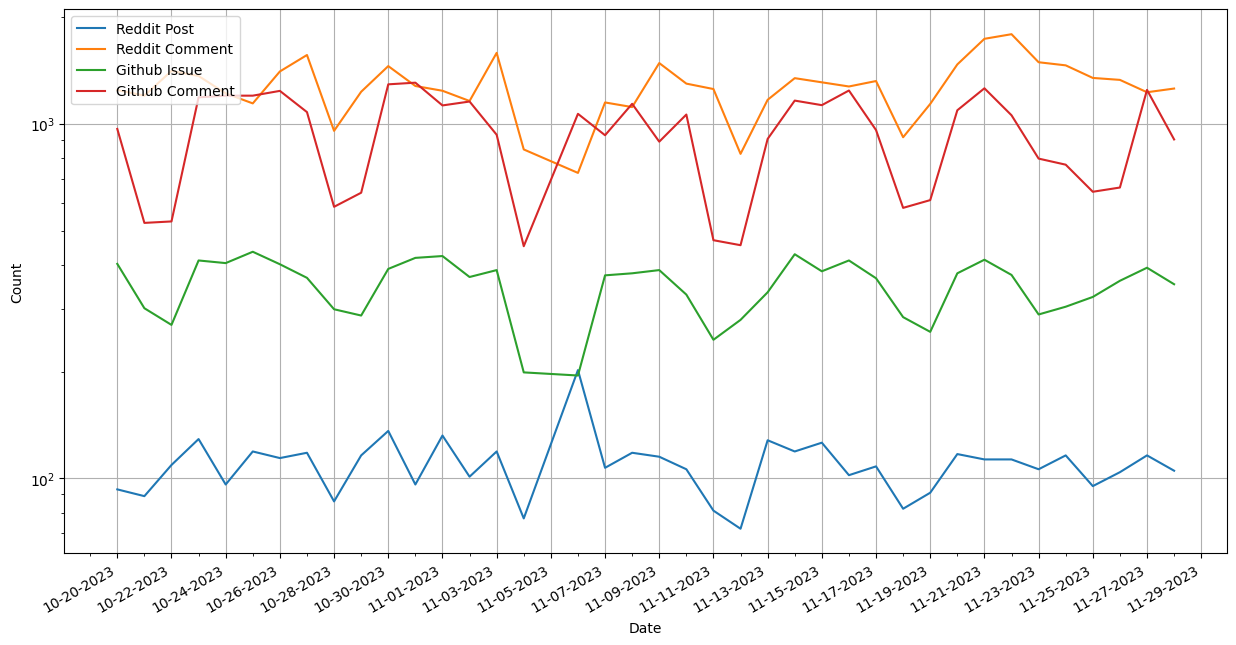

In [77]:
all_data_over_time("all_data_over_time.pdf")

In [78]:
def politics_posts_over_daily(filename):
    query1 = """
            select 
                count(*) as post_count,
                date_trunc('day', created_utc) as day
            from reddit_posts 
            where subreddit='politics'
            and created_utc >= '2023-11-01' and created_utc < '2023-11-15'
            group by day
            ;
            """

    data1= run_query(query1)

    # Create a DataFrame from the query result
    df1 = pd.DataFrame(data1, columns=['post_count', 'day'])

    # sort the dataframe by date
    df1 = df1.sort_values(by='day', ascending=True)

    # Create line graph
    fig, ax = plt.subplots( figsize=(9, 4))
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d-%Y'))
    ax.plot(df1['day'], df1['post_count'])
    ax.scatter(df1['day'], df1['post_count'],alpha=0.9, marker='o')
    fig.autofmt_xdate()
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Posts')
    ax.grid(axis='y')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()



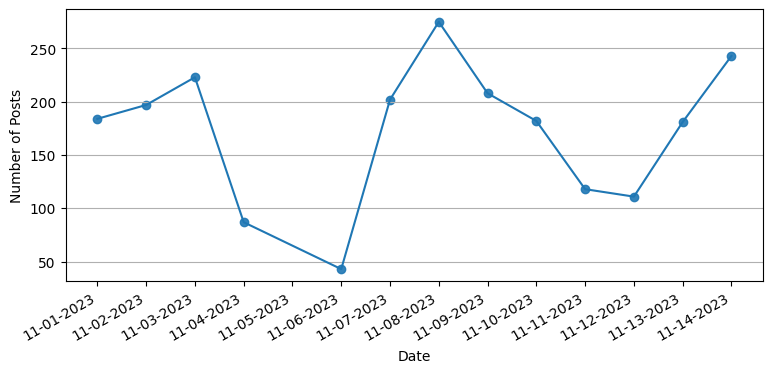

In [79]:
politics_posts_over_daily("politics_posts_over_daily.pdf")

In [80]:
def politics_comments_over_hourly(filename):
    query1 = """
            select 
                count(*) as comment_count,
                date_trunc('hour',created_utc) as day
            from reddit_comments 
            where subreddit='politics'
            and created_utc >= '2023-11-01' and created_utc < '2023-11-15'
            group by day
            ;
            """

    data1= run_query(query1)

    # Create a DataFrame from the query result
    df1 = pd.DataFrame(data1, columns=['comment_count', 'day'])
    # sort
    df1 = df1.sort_values(by='day', ascending=True)
    # Create bar graph
    fig, ax = plt.subplots( figsize=(15, 8))
    ax.plot(df1['day'], df1['comment_count'])
    ax.scatter(df1['day'], df1['comment_count'],alpha=0.7, marker='o',s=10)
    fig.autofmt_xdate()
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=1))
    ax.xaxis.set_minor_locator(matplotlib.dates.HourLocator(interval=1))
    ax.tick_params(which='minor', color='grey')
    ax.set_xlabel('Day and Hour')
    ax.set_ylabel('Number of Comments')
    ax.grid(axis='y',alpha=0.7)
    ax.grid(axis='x', which='major',alpha=0.7)

    ax2 = ax.twiny()
    ax2.plot(df1['day'], df1['comment_count'])
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=1))
    ax2.xaxis.set_minor_locator(matplotlib.dates.HourLocator(byhour=range(0,24,4)))
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_major_formatter("")
    ax2.tick_params(which='minor', size=5)
    ax2.grid(axis='x', which='minor', color='grey', linestyle='dotted',alpha=0.5)

    plt.savefig(filename, bbox_inches='tight')
    plt.show()

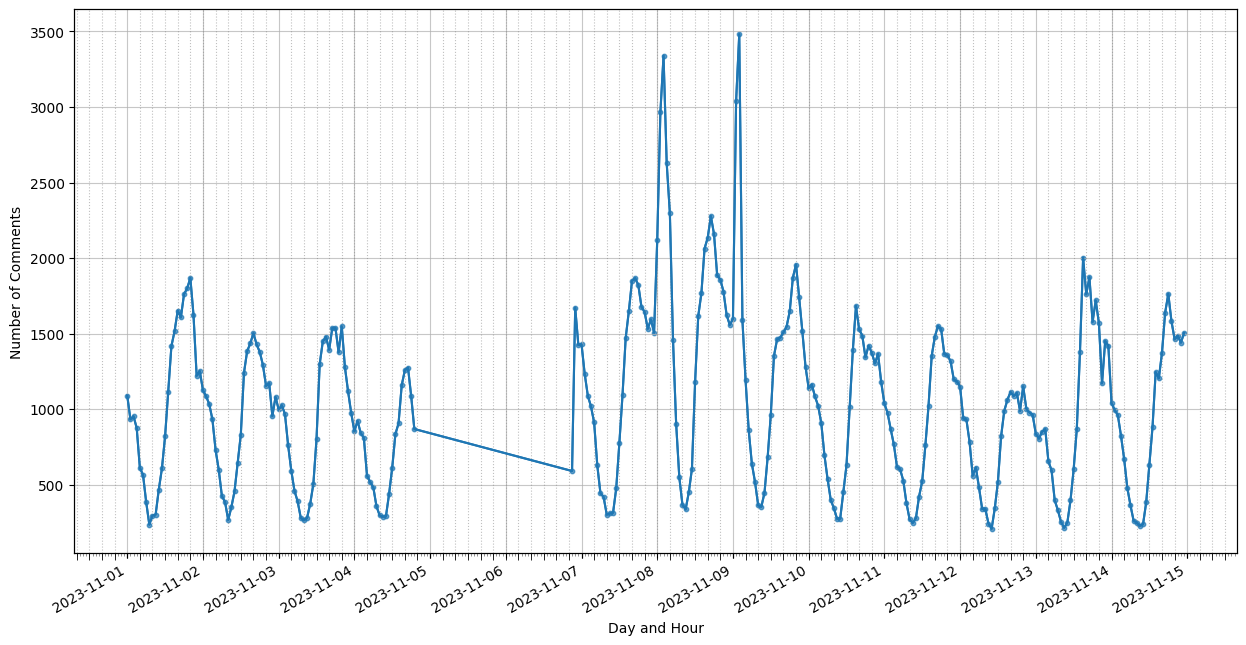

In [81]:
politics_comments_over_hourly("politics_comments_over_hourly.pdf")

# Reddit Comments CDF

In [82]:
def reddit_comments_per_post_cdf(filename):
    query = """
        select 
            count(*) as comment_count, 
            post_name 
        from reddit_comments 
        where subreddit!='politics'
        group by post_name
        order by comment_count;
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['comment_count', 'post_name'])
    # Plot the CDF
    plt.hist(df['comment_count'], cumulative=True, density=True, bins=100, histtype='step', label='Reddit Posts')
    plt.xlabel('Number of Comments')
    plt.ylabel('Probability')
    plt.xscale('log')
    plt.grid()
    plt.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

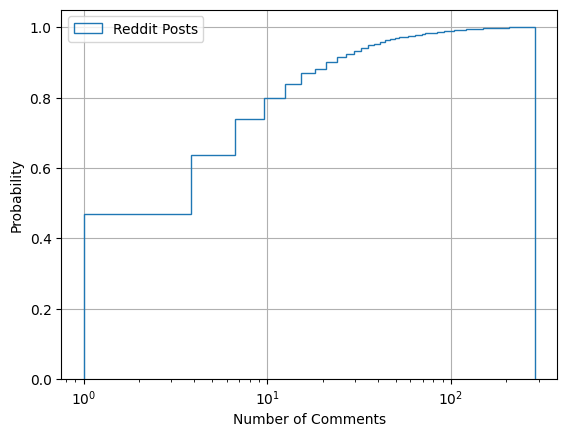

In [83]:
reddit_comments_per_post_cdf("comments_per_post_cdf.pdf")

In [84]:
def github_comments_per_issue(filename):
    query = """
        select 
            count(*) as comment_count, 
            issue_number 
        from github_comments 
        group by issue_number
        order by comment_count;
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['comment_count', 'issue_number'])
    # Plot the CDF
    plt.hist(df['comment_count'], cumulative=True, density=True, bins=100, histtype='step', label='Github Issues')
    plt.xlabel('Number of Comments')
    plt.ylabel('Probability')
    plt.xscale('log')
    plt.grid()
    plt.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

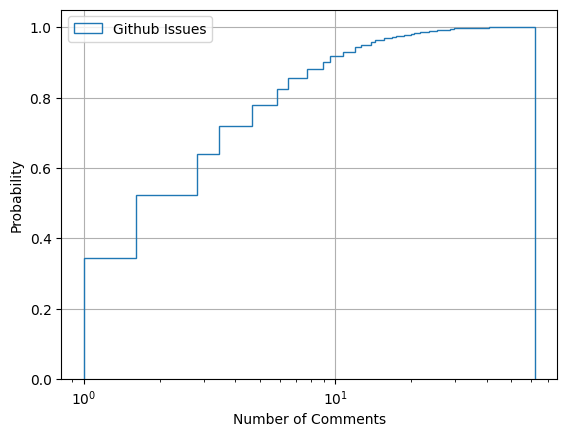

In [85]:
github_comments_per_issue("github_comments_per_issue.pdf")

In [87]:
def compare_comments_per_submission_cdf(filename):
    query = """
        select 
            count(*) as comment_count, 
            post_name 
        from reddit_comments 
        where subreddit!='politics'
        group by post_name
        order by comment_count;
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['comment_count', 'post_name'])
    # Plot the CDF
    plt.hist(df['comment_count'], cumulative=True, density=True, bins=100, histtype='step', label='Reddit Posts')

    query = """
        select 
            count(*) as comment_count, 
            issue_number 
        from github_comments 
        group by issue_number
        order by comment_count;
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['comment_count', 'issue_number'])
    # Plot the CDF
    plt.hist(df['comment_count'], cumulative=True, density=True, bins=100, histtype='step', label='Github Issues')
    plt.xlabel('Number of Comments')
    plt.ylabel('Probability')
    plt.xscale('log')
    plt.grid()
    plt.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

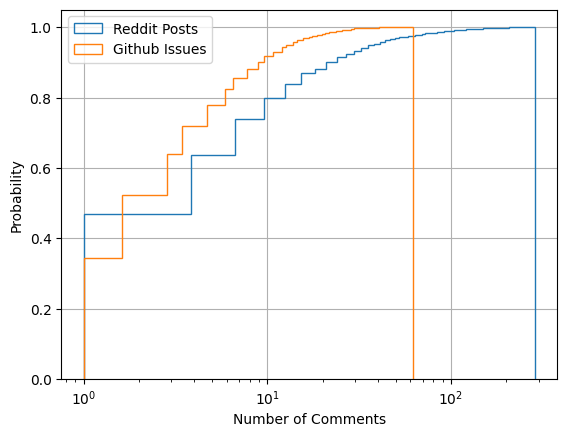

In [88]:
compare_comments_per_submission_cdf("compare_comments_per_submission_cdf.pdf")

In [89]:
def compare_subreddit_comments_on_post(filename):
    query = """
        select 
            count(*) as comment_count, 
            subreddit 
        from reddit_comments 
        where subreddit!='politics'
        group by subreddit, post_name
        order by comment_count;
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['comment_count', 'subreddit'])
    # Plot the CDF
    for subreddit in subreddit_names:
        plt.hist(df[df['subreddit'] == subreddit]['comment_count'], cumulative=True, density=True, bins=100, histtype='step', label=subreddit)
    plt.xlabel('Number of Comments')
    plt.ylabel('Probability')
    plt.xscale('log')
    plt.grid()
    plt.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

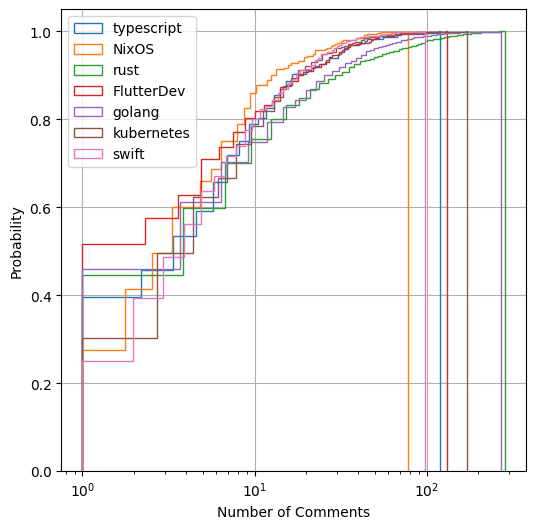

In [77]:
compare_subreddit_comments_on_post("compare_subreddit_comments_on_post.pdf")    

In [104]:
def compare_repo_comments_on_issue(filename):
    query = """
        select 
            count(*) as comment_count, 
            repo_name 
        from github_comments 
        group by repo_name, issue_number
        order by comment_count;
        """
    data = run_query(query)
    # Create a DataFrame from the query result
    df = pd.DataFrame(data, columns=['comment_count', 'repo_name'])
    # Plot the CDF
    

    plt.figure(figsize=(10, 8))
    for repo in repo_names:
        plt.hist(df[df['repo_name'] == repo]['comment_count'], cumulative=True, density=True, bins=100, histtype='step', label=repo)
    plt.xlabel('Number of Comments')
    plt.ylabel('Probability')
    plt.xscale('log')
    plt.grid()
    
    plt.legend(fontsize='small')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

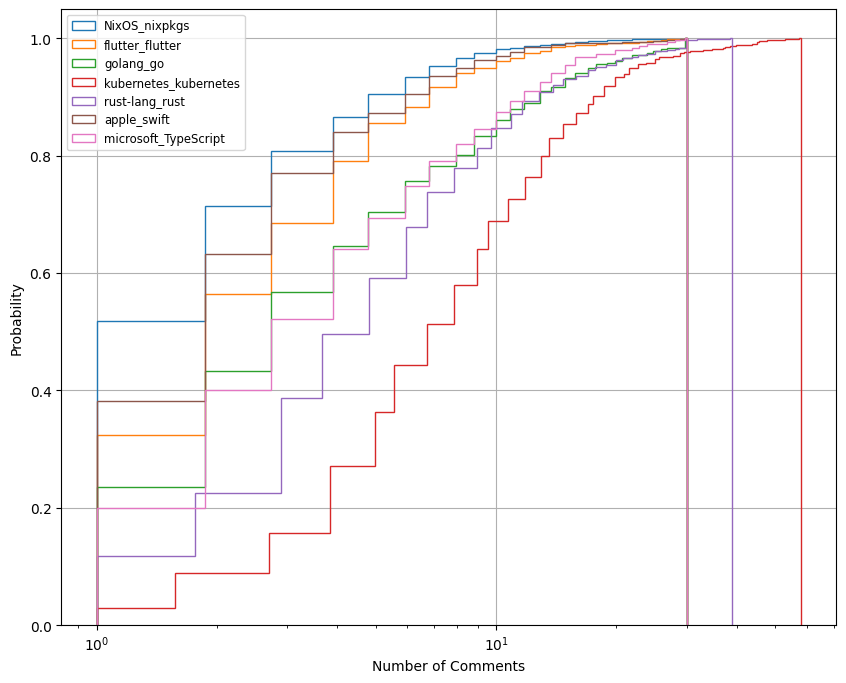

In [105]:
compare_repo_comments_on_issue("compare_repo_comments_on_issue.pdf")